# EPRL vertex renormalization

Notebook for the analysis of EPRL vertex renormalization

## Setup

In [1]:
using CSV
using DataFrames
using HalfIntegers, JLD2, Distributions, Random
using LaTeXStrings

In [2]:
using Statistics
using StatsBase
using StatsPlots

In [3]:
pgfplotsx()
theme(:default)
default(
    markerstrokewidth = 0,
    markerstrokealpha = 0,
    grid = :true,
    gridlinewidth = 0.5,
    fontfamily="Computer Modern",
    framestyle=:box,
    size=(800,300),
    margin=5Plots.mm
)
scalefontsizes(1.7)

# MC Estimate with $N_{mc} = 10^5$ 

In [4]:
BASE_DATA_DIRECTORY = "../../data";

function get_data(Nmc, Dl, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/vertex_renormalization/jb_0.5/monte_carlo/Nmc_$(Nmc)/EPRL/immirzi_0.1/Dl_$(Dl)/weight_1.0/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

get_data (generic function with 1 method)

In [5]:
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(100000,10, trial).amp[id] - get_data(100000,10, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc100K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc100K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

relative_error_Nmc100K = error_Nmc100K./amplitude_Nmc100K;

plot1 = Plot{Plots.PGFPlotsXBackend() n=1}


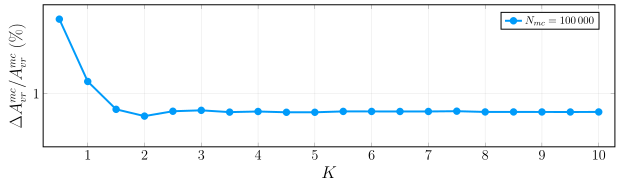

In [53]:
plot1 = plot(0.5:0.5:10,
               [100*relative_error_Nmc100K],
               label = [L"$N_{mc}=100\,000$"],
               yscale=:log10,
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               size = (900, 300),
               ylim = (0.92,1.15),
               yticks = [1],
               ylabel = L"\Delta A_{vr}^{mc}/A_{vr}^{mc} \ (\%)",
               xlabel = L"K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               legend_column = -1,
               legend = (0.80, 0.95),
               legendfontsize=11,
               yguidefontsize=16,
               xguidefontsize=16,
               )
#title!(plot1, "Monte Carlo error")
savefig(plot1,"./plots/EPRL/vertex_renormalization/VR_EPRL_relative_errors.svg")


@show plot1

# Extrapolation

We now deal with the extrapolation. We use the _numerically stable_ version:

$$
W_{\Delta l} (K) = W(K, \Delta l) - \frac{(W(K, \Delta l) - W(K, \Delta l-1))^2}{W(K, \Delta l) - 2W(K, \Delta l-1) + W(K, \Delta l-2)}
$$

In [11]:
function extrapolate(dataDl,dataDlm1,dataDlm2)
    dataDl - (dataDl - dataDlm1)^2/(dataDl - 2*dataDlm1 + dataDlm2);
end

extrapolate (generic function with 1 method)

Let's extrapolate each trial *independently*. For each trial we sum all layers and then we extrapolate. 

We repeat this for all trials, averaging the final results.

In [14]:
test_ampl_DL10_Nmc100K = DataFrame()
for trial in 1:20
    test_ampl_DL10_Nmc100K[!,"$(trial)"]=[get_data(100000,10, trial).amp[id] for id in 2:21]
end

test_ampl_DL9_Nmc100K = DataFrame()
for trial in 1:20
    test_ampl_DL9_Nmc100K[!,"$(trial)"]=[get_data(100000,9, trial).amp[id] for id in 2:21]
end

test_ampl_DL8_Nmc100K = DataFrame()
for trial in 1:20
    test_ampl_DL8_Nmc100K[!,"$(trial)"]=[get_data(100000,8, trial).amp[id] for id in 2:21]
end

test_ampl_extrapolation_Nmc100K = DataFrame()
for trial in 1:20
    test_ampl_extrapolation_Nmc100K[!,"$(trial)"]= extrapolate.(test_ampl_DL10_Nmc100K[!,"$(trial)"],test_ampl_DL9_Nmc100K[!,"$(trial)"],test_ampl_DL8_Nmc100K[!,"$(trial)"])
end

avg_ampl_extrapolation_Nmc100K =  [mean(row) for row in eachrow(test_ampl_extrapolation_Nmc100K)]
var_ampl_extrapolation_Nmc100K =  [var(row) for row in eachrow(test_ampl_extrapolation_Nmc100K)];

error_Nmc100K_extrap = sqrt.([var_ampl_extrapolation_Nmc100K[id] for id in 1:20]);

relative_error_Nmc100K_extrap = error_Nmc100K_extrap./avg_ampl_extrapolation_Nmc100K;

plot1 = Plot{Plots.PGFPlotsXBackend() n=1}


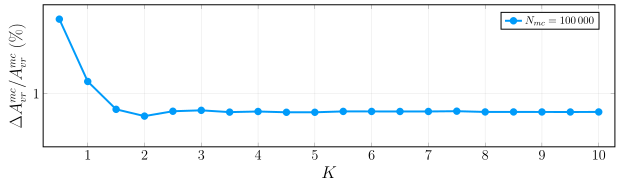

In [52]:
pgfplotsx()
plot1 = plot(0.5:0.5:10,
               [100*relative_error_Nmc100K_extrap],
               label = [L"$N_{mc}=100\,000$"],
               yscale=:log10,
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               size = (900, 300),
               ylim = (0.92,1.15),
               yticks = [1],
               ylabel = L"\Delta A_{vr}^{mc}/A_{vr}^{mc} \ (\%)",
               xlabel = L"K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               legend_column = -1,
               legend = (0.80, 0.95),
               legendfontsize=11,
               yguidefontsize=16,
               xguidefontsize=16,
               )
#title!(plot1, "Monte Carlo error")
savefig(plot1,"./plots/EPRL/vertex_renormalization/VR_EPRL_extrapolations_relative_errors.svg")

@show plot1

Check that the sequence $A_{vr}(K,\Delta l)$ is linearly convergent. We compute the ratios $\lambda_K(\Delta l)$ and infer that the limit $\Delta l \to \infty$ is finite and smaller than 1.

In [16]:
function make_lambda(data)
    (data[3:end] .- data[2:end-1]) ./ (data[2:end-1] .- data[1:end-2])
end

make_lambda (generic function with 1 method)

In [17]:
data_10_shell = zeros(20, 11);

In [24]:
for Dl_index = 1:11

layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(100000,Dl_index-1, trial).amp[id] - get_data(100000,Dl_index-1, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc100K = [sum(layers_average[1:id]) for id in 1:20];
    
data_10_shell[:, Dl_index] .= amplitude_Nmc100K[:]
    
end

In [25]:
data_10_shell

20×11 Matrix{Float64}:
 1.82982e-19  8.98426e-19  1.65908e-18  …  3.3713e-18   3.43149e-18
 2.71992e-19  1.4365e-18   2.78416e-18     6.21306e-18  6.34635e-18
 2.78943e-19  1.49197e-18  2.92276e-18     6.71325e-18  6.86685e-18
 2.79696e-19  1.49933e-18  2.94393e-18     6.81959e-18  6.97925e-18
 2.7981e-19   1.50062e-18  2.94807e-18     6.84748e-18  7.00919e-18
 2.79833e-19  1.50091e-18  2.94905e-18  …  6.85614e-18  7.01863e-18
 2.79839e-19  1.50099e-18  2.94937e-18     6.85951e-18  7.02235e-18
 2.7984e-19   1.50101e-18  2.94946e-18     6.86076e-18  7.02375e-18
 2.79841e-19  1.50102e-18  2.9495e-18      6.86137e-18  7.02444e-18
 2.79841e-19  1.50103e-18  2.94952e-18     6.86165e-18  7.02476e-18
 2.79841e-19  1.50103e-18  2.94952e-18  …  6.86178e-18  7.02491e-18
 2.79841e-19  1.50103e-18  2.94953e-18     6.86184e-18  7.02498e-18
 2.79841e-19  1.50103e-18  2.94953e-18     6.86188e-18  7.02503e-18
 2.79841e-19  1.50103e-18  2.94953e-18     6.8619e-18   7.02505e-18
 2.79841e-19  1.50103e-18

In [29]:
lambda20 = make_lambda(data_10_shell[20,:]);
lambda15 = make_lambda(data_10_shell[15,:]);
lambda10 = make_lambda(data_10_shell[10,:]);

plotib0 = Plot{Plots.PGFPlotsXBackend() n=3}


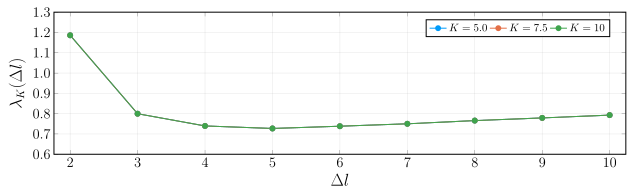

In [40]:
plotib0 = plot(
    2:10,
    [   
        lambda10,
        lambda15,
        lambda20,
    ],
    label = [ L"K=5.0" L"K=7.5" L"K=10"],
    xlabel = L"\Delta l",
    ylabel = L"\lambda_K(\Delta l)",
    markershape = [:circle :circle :circle],
    shape = [:circle :circle :circle],
    xticks = 2:10,
    ylim = (0.6, 1.3),
    size = (900, 300),
    legend = (0.65, 0.95),
    legend_column = -1,
    legendfontsize=11,
    yguidefontsize=16,
    xguidefontsize=16,
)

savefig(plotib0,"./plots/EPRL/vertex_renormalization/VR_lambda_K.svg")

@show plotib0